## Trabajo Fin de Grado
### Gestor de Quirófanos
### Implementación de Algoritmo Genético para asignación de quirófanos

#### Autor: Jesús García Armario

In [1]:
# Imports necesarios
import numpy as np
import pandas as pd
from deap import base, creator, tools, algorithms
import sys
sys.path.append('../')
from Heuristicas.Utils import Quirofano, ActoQuirurgico, Heuristicas
import random
import math
import matplotlib.pyplot as plt

In [2]:
# Importamos el listado preprocesado de una especialidad para las pruebas
filename = '..\\..\\Datos\\Listados_Preprocesados\\ListadoInterv_Preprocesado_MAXILOFACIAL.xlsx'
df = pd.read_excel(filename)
# Seleccionamos una muestra aleatoria de 100 pacientes
df = df.sample(n=100, random_state=1)
# Nos quedamos sólo con el NHC, Ponderación y duración
df = df[['NHC', 'PONDERACIÓN', 'DURACIÓN']]
# Sumamos a la duración 25 minutos por paciente para tener en cuenta el tiempo de preparación
df['DURACIÓN'] = df['DURACIÓN'] + 25
ventana = 30
# Dividimos la duración entre la ventana y redondeamos hacia arriba
df['DURACIÓN'] = df['DURACIÓN'].apply(lambda x: math.ceil(x/ventana))
# Creamos un set de actos quirúrgicos
actos_pendientes = list()
i = 0
for elemento in df.itertuples():
    actos_pendientes.append(ActoQuirurgico(i, elemento[3], elemento[1], elemento[2]))
    i += 1

In [3]:
# Definimos un cromosoma como una lista de tamaño N
# donde N es el número de slots temporales disponibles
# El ID de la operación ocupará la posición del slot temporal o 'V' si no se ha asignado
# El cromosoma se codifica como una lista de enteros
# Con separadores representados por caracteres especiales, siendo 'A' el separador de quirófanos
# y 'B' el separador de días
def cromosomaAleatorio(tiempos, quirofanos, dias, actos_pendientes):
    actos = actos_pendientes.copy()
    cromosoma = []
    # Creamos un cromosoma aleatorio
    for i in range(dias):
        for j in range(quirofanos):
            T = tiempos
            while T > 0:
                if len(actos) == 0:
                    cromosoma.append('V')
                    T -= 1
                else:
                    acto = random.choice(actos)
                    intentos = 0
                    while acto.getDuracion() > T:
                        acto = random.choice(actos)
                        intentos += 1
                        if intentos > len(actos):
                            cromosoma.append('V')
                            T -= 1
                            break
                    cromosoma.append(acto.getId())
                    actos.remove(acto)
                    T -= acto.getDuracion()
            cromosoma.append('A')
        cromosoma.append('B')
    return cromosoma

In [4]:
# Definimos al individuo
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("cromosoma", cromosomaAleatorio, tiempos=16, quirofanos=3, dias=5, actos_pendientes=actos_pendientes)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.cromosoma)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [5]:
# Variables globales
# Definimos la función de fitness
def evaluar(individual, tiempos, quirofanos, dias, actos_pendientes):
    if not validar(individual, tiempos, actos_pendientes):
        return (distance(individual, tiempos, actos_pendientes)),
    # Calculamos el fitness como la suma de las ponderaciones de los actos quirúrgicos
    fitness = 0
    tiempo_quirofano = 0
    huecos_vacios = 0
    # Calculamos el fitness
    for elemento in individual:
        if elemento == 'A':
            if tiempo_quirofano>0:
                huecos_vacios += tiempos/tiempo_quirofano
            else:
                huecos_vacios += tiempos
            continue
        if elemento == 'B':
            continue
        if elemento == 'V':
            tiempo_quirofano += 0
            continue
        tiempo_quirofano += actos_pendientes[elemento].getDuracion()
        fitness += actos_pendientes[elemento].getPrioridad()
    return (huecos_vacios/fitness),

# Definimos la función de validez
def validar(individual, tiempos, actos_pendientes):
    # Comprobamos que la duración de las intervenciones no supera el tiempo disponible
    tiempo_quirofano = 0
    for elemento in individual:
        if elemento == 'A' or elemento == 'B':
            tiempo_quirofano = 0
            continue
        if elemento == 'V':
            tiempo_quirofano += 0
            continue
        tiempo_quirofano += actos_pendientes[elemento].getDuracion()
        if tiempo_quirofano > (tiempos+1):
            return False
    return True

def distance(individual,tiempos,actos_pendientes):
    # Calculamos la distancia entre los actos quirúrgicos
    dist = 0
    tiempo_quirofano = 0
    for elemento in individual:
        if elemento == 'A' or elemento == 'B':
            tiempo_quirofano = 0
            continue
        if elemento == 'V':
            tiempo_quirofano += 0
            continue
        tiempo_quirofano += actos_pendientes[elemento].getDuracion()
        if tiempo_quirofano > (tiempos+1):
            dist += 1
    return dist


In [6]:
def cruce(ind1, ind2):
    # Obtenemos una copia de los padres
    hijo1 = ind1.copy()
    hijo2 = ind2.copy()
    padre1 = ind1.copy()
    padre2 = ind2.copy()
    # Eliminamos los separadores de los padres
    padre1 = [i for i in ind1 if i!='A' and i!='B']
    padre2 = [i for i in ind2 if i!='A' and i!='B']
    # Selecccionamos dos puntos de cruces aleatorios
    punto1 = random.randint(0, len(ind1)-1)
    while ind1[punto1] == 'A' and ind1[punto1] == 'B':
        punto1 = random.randint(0, len(ind1)-1)
    punto2 = random.randint(0, len(ind1)-1)
    while ind1[punto2] == 'A' and ind1[punto2] == 'B' and punto2 == punto1:
        punto2 = random.randint(0, len(ind1)-1)
    punto3 = random.randint(0, len(ind2)-1)
    while ind2[punto3] == 'A' and ind2[punto3] == 'B':
        punto3 = random.randint(0, len(ind2)-1)
    punto4 = random.randint(0, len(ind2)-1)
    while ind2[punto4] == 'A' and ind2[punto4] == 'B' and punto4 == punto3:
        punto4 = random.randint(0, len(ind2)-1)
    # Añadimos los genes del padre 2 al hijo 1 hasta la región de cruce
    if punto1>punto2:
        punto = punto1
        punto1 = punto2
        punto2 = punto
    if punto3>punto4:
        punto = punto3
        punto3 = punto4
        punto4 = punto
    for i in range(len(hijo1)):
        if i < punto1 or i > punto2:
            if hijo1[i] == 'A' or hijo1[i] == 'B':
                continue
            elif len(padre2) == 0:
                break
            hijo1[i] = padre2.pop(0)
    # Añadimos los genes del padre 1 al hijo 2 hasta la región de cruce
    for i in range(len(hijo2)):
        if i < punto3 or i > punto4:
            if hijo2[i] == 'A' or hijo2[i] == 'B':
                continue
            elif len(padre1) == 0:
                break
            hijo2[i] = padre1.pop(0)
    return hijo1, hijo2
def mutacion(individual):
    # Calculamos los índices posibles de intercambio
    indices = [i for i in range(len(individual)) if individual[i] != 'A' and individual[i] != 'B']
    # Seleccionamos dos índices aleatorios
    indices = random.choices(indices, k=2)
    # Intercambiamos los valores
    individual[indices[0]], individual[indices[1]] = individual[indices[1]], individual[indices[0]]
    return individual

In [7]:
toolbox.register("evaluate", evaluar, tiempos=16, quirofanos=3, dias=5, actos_pendientes=actos_pendientes)
toolbox.register("mate", cruce)
toolbox.register("mutate", mutacion)
toolbox.register("select", tools.selTournament, tournsize=3)

In [8]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean) 
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max) 

In [9]:
# Definimos el algoritmo genético
def algoritmo_genetico(poblacion, probabilidad_cruce, probabilidad_mutacion, numero_generaciones):
    # Evaluamos la población
    fitnesses = list(map(toolbox.evaluate, poblacion))
    for ind, fit in zip(poblacion, fitnesses):
        ind.fitness.values = fit
    # Inicializamos las estadísticas
    record = stats.compile(poblacion)
    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + (stats.fields if stats else [])
    # Guardamos las estadísticas
    logbook.record(gen=0, evals=len(poblacion), **record)
    print(logbook.stream)
    # Iniciamos contador de generaciones sin mejora
    contador = 0
    hof = tools.HallOfFame(1)
    hof.update(poblacion)
    # Ejecutamos el algoritmo genético
    for g in range(1, numero_generaciones):
        # Seleccionamos a la población
        poblacion = toolbox.select(poblacion, len(poblacion))
        # Clonamos a los individuos
        hijos = list(map(toolbox.clone, poblacion))
        # Aplicamos el cruce
        for hijo1, hijo2 in zip(hijos[::2], hijos[1::2]):
            if random.random() < probabilidad_cruce:
                toolbox.mate(hijo1, hijo2)
                del hijo1.fitness.values
                del hijo2.fitness.values
        # Aplicamos la mutación
        for hijo in hijos:
            if random.random() < probabilidad_mutacion:
                toolbox.mutate(hijo)
                del hijo.fitness.values
        # Evaluamos a los individuos con fitness inválido
        invalid_ind = [ind for ind in hijos if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        # Reemplazamos a la población
        poblacion[:] = hijos
        # Guardamos las estadísticas
        record = stats.compile(poblacion)
        logbook.record(gen=g, evals=len(poblacion), **record)
        print(logbook.stream)
        # Comprobamos si el mejor individuo ha mejorado
        if hof[0].fitness.values[0] > record['min']:
            contador = 0
        else:
            contador += 1
        hof.update(poblacion)
        # Si no ha mejorado en 50 generaciones, paramos
        if contador == 100:
            break
    return poblacion, logbook, hof

In [10]:
poblacion = toolbox.population(n=200)
# Cargamos el algoritmo genético
poblacion, logbook, hof = algoritmo_genetico(poblacion, probabilidad_cruce=0.85, probabilidad_mutacion=0.15, numero_generaciones=1000)

gen	evals	avg    	std    	min       	max
0  	200  	4.05003	1.77123	0.00290703	9  
1  	200  	2.55516	1.26339	0.00290703	6  
2  	200  	1.60046	1.00425	0.00290703	4  
3  	200  	0.881105	0.838843	0.00290666	4  
4  	200  	0.337157	0.60937 	0.00282518	4  
5  	200  	0.182586	0.535416	0.00282518	3  
6  	200  	0.13764 	0.464826	0.00282518	3  
7  	200  	0.137588	0.453957	0.00282518	4  
8  	200  	0.152575	0.47616 	0.00282437	3  
9  	200  	0.137551	0.419627	0.00281838	2  
10 	200  	0.117604	0.425648	0.00281838	3  
11 	200  	0.127557	0.422772	0.00281838	3  
12 	200  	0.102627	0.38662 	0.00281824	2  
13 	200  	0.0975982	0.354234	0.00281607	3  
14 	200  	0.102625 	0.423646	0.00281824	4  
15 	200  	0.117594 	0.425651	0.0028143 	3  
16 	200  	0.0976495	0.406783	0.0028143 	3  
17 	200  	0.102635 	0.411672	0.00281116	3  
18 	200  	0.107607 	0.391699	0.00281116	2  
19 	200  	0.13762  	0.579714	0.00281116	5  
20 	200  	0.112576 	0.42111 	0.00281116	4  
21 	200  	0.142561 	0.499684	0.00280956	3  
22 	200  	

In [11]:
print("Mejor individuo: ", hof[0])
print("Fitness del mejor: ", hof[0].fitness.values[0])

Mejor individuo:  [70, 55, 47, 17, 67, 68, 'A', 92, 91, 65, 'V', 57, 'A', 81, 88, 'V', 95, 'A', 'B', 58, 27, 62, 0, 'A', 61, 32, 1, 73, 'A', 41, 83, 42, 'V', 60, 'A', 'B', 3, 16, 'A', 87, 36, 40, 'A', 9, 48, 59, 8, 96, 64, 'A', 'B', 4, 89, 31, 26, 'A', 34, 93, 82, 19, 'A', 80, 29, 10, 46, 30, 43, 90, 'A', 'B', 2, 72, 22, 76, 45, 'A', 77, 56, 37, 50, 97, 'A', 14, 84, 38, 44, 85, 'A', 'B']
Fitness del mejor:  0.0027933718913563097


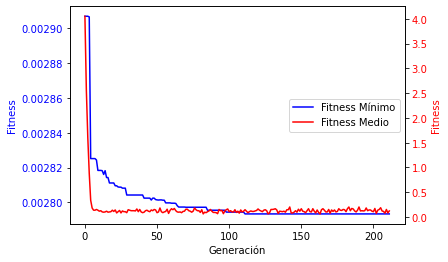

In [12]:
def representaAlgoritmoGenetico(logbook):
    # Representamos el logbook
    gen = logbook.select("gen")
    fit_mins = logbook.select("min")
    fit_maxs = logbook.select("max")
    fit_averages = logbook.select("avg")
    fig, ax1 = plt.subplots()
    line1 = ax1.plot(gen, fit_mins, "b-", label="Fitness Mínimo")
    ax1.set_xlabel("Generación")
    ax1.set_ylabel("Fitness", color="b")
    for tl in ax1.get_yticklabels():
        tl.set_color("b")
    ax2 = ax1.twinx()
    line2 = ax2.plot(gen, fit_averages, "r-", label="Fitness Medio")
    ax2.set_ylabel("Fitness", color="r")
    for tl in ax2.get_yticklabels():
        tl.set_color("r")
    lns = line1 + line2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc="center right")
    plt.show()

representaAlgoritmoGenetico(logbook)

Incluimos las heurísticas como parte de la población inicial

In [13]:
# Función que traduce el fenotipo de la heurística a un cromosoma
def fenotipoACromosoma(fenotipo):
    dias = len(fenotipo)
    quirofanos = len(fenotipo[0])
    cromosoma = []
    for i in range(dias):
        for j in range(quirofanos):
            for acto in fenotipo[i][j].getActos():
                cromosoma.append(acto.getId())
            cromosoma.append('A')
        cromosoma.append('B')
    return cromosoma

modelo_heur = Heuristicas(actos_pendientes, 3, 5, 16)
asignacionLPT, _ = modelo_heur.ejecutaHeuristica()
asignacionLPTEDD, _ = modelo_heur.ejecutaHeuristica("LPTEDD")

In [14]:
toolbox.register("heuristicaLPT", fenotipoACromosoma,asignacionLPT)
toolbox.register("heuristicaLPTEDD", fenotipoACromosoma,asignacionLPTEDD)
toolbox.register("indModelo", tools.initIterate, creator.Individual, toolbox.heuristicaLPT)
toolbox.register("indModeloDos", tools.initIterate, creator.Individual, toolbox.heuristicaLPTEDD)

In [15]:
ind = toolbox.indModelo()

In [16]:
# Iniciamos población aleatoria
poblacion = toolbox.population(n=200)
# Sustituimos a dos individuos aleatorios por los individuos de las heurísticas
poblacion[random.randint(0, len(poblacion)-1)] = toolbox.indModelo()
poblacion[random.randint(0, len(poblacion)-1)] = toolbox.indModeloDos()
# Cargamos el algoritmo genético
poblacion, logbook, hof_comb = algoritmo_genetico(poblacion, probabilidad_cruce=0.85, probabilidad_mutacion=0.15, numero_generaciones=1000)

gen	evals	avg    	std    	min       	max
0  	200  	3.83509	1.68436	0.00285208	9  
1  	200  	2.56522	1.29794	0.00286404	6  
2  	200  	1.47079	0.920204	0.00286404	4  
3  	200  	0.861609	0.746752	0.00286404	3  
4  	200  	0.323284	0.524884	0.00286404	3  
5  	200  	0.0592194	0.285503	0.00286404	2  
6  	200  	0.0886947	0.34227 	0.00286294	2  
7  	200  	0.0931605	0.362398	0.00278278	2  
8  	200  	0.132713 	0.471588	0.00278278	2  
9  	200  	0.0826814	0.321203	0.00278278	2  
10 	200  	0.137603 	0.475471	0.00278278	3  
11 	200  	0.15751  	0.469252	0.00276481	2  
12 	200  	0.0876427	0.370575	0.00275456	2  
13 	200  	0.0876282	0.383834	0.00275456	3  
14 	200  	0.142528 	0.489584	0.00275456	3  
15 	200  	0.0875507	0.295537	0.00275456	2  
16 	200  	0.107545 	0.378736	0.00274359	2  
17 	200  	0.112541 	0.396663	0.00275456	2  
18 	200  	0.0825929	0.336431	0.00274491	2  
19 	200  	0.122521 	0.418325	0.00274491	2  
20 	200  	0.137479 	0.431401	0.00274491	2  
21 	200  	0.117534 	0.425667	0.00274491	3  
2

Mejor individuo:  [4, 41, 83, 'A', 50, 63, 32, 76, 96, 'A', 97, 93, 12, 51, 80, 'A', 'B', 62, 60, 15, 82, 56, 8, 'A', 58, 16, 79, 48, 'A', 33, 85, 26, 69, 9, 39, 'A', 'B', 61, 21, 1, 87, 29, 'A', 35, 81, 5, 47, 'A', 23, 52, 6, 25, 'A', 'B', 38, 11, 28, 45, 92, 19, 'A', 17, 72, 66, 'V', 'A', 13, 67, 89, 90, 31, 'A', 'B', 53, 91, 49, 'A', 0, 30, 44, 54, 'A', 77, 37, 70, 'V', 14, 'A', 'B']
Fitness del mejor:  0.0027037337987865615


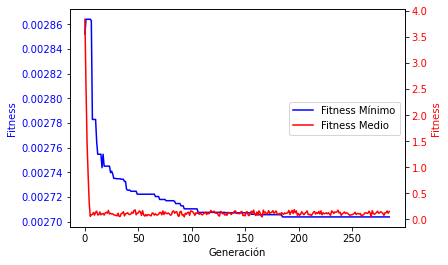

In [17]:
print("Mejor individuo: ", hof_comb[0])
print("Fitness del mejor: ", hof_comb[0].fitness.values[0])
representaAlgoritmoGenetico(logbook)

Fitness LPT:  0.00477062515720506
Fitness LPTEDD:  0.004877853334892653
Fitness Combinado:  0.0027037337987865615
Fitness Genético:  0.0027933718913563097


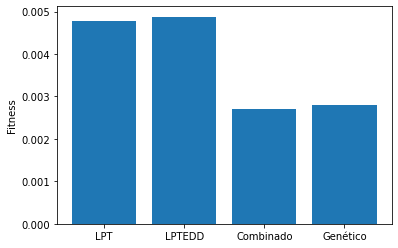

In [20]:
# Se representan los fitness de los mejores individuos
mejor_LPT = toolbox.indModelo()
mejor_LPTEDD = toolbox.indModeloDos()
mejor_comb = hof_comb[0]
mejor_gene = hof[0]

# Se evalúan
mejor_LPT.fitness.values = toolbox.evaluate(mejor_LPT)
mejor_LPTEDD.fitness.values = toolbox.evaluate(mejor_LPTEDD)
mejor_comb.fitness.values = toolbox.evaluate(mejor_comb)
mejor_gene.fitness.values = toolbox.evaluate(mejor_gene)

# Se representan
print("Fitness LPT: ", mejor_LPT.fitness.values[0]) 
print("Fitness LPTEDD: ", mejor_LPTEDD.fitness.values[0])
print("Fitness Combinado: ", mejor_comb.fitness.values[0])
print("Fitness Genético: ", mejor_gene.fitness.values[0])

# Se representan los resultados
def representaResultados(mejor_LPT, mejor_LPTEDD, mejor_comb, mejor_gene):
    # Se representan los resultados
    fig, ax = plt.subplots()
    ax.bar([1,2,3,4],[mejor_LPT.fitness.values[0], mejor_LPTEDD.fitness.values[0], mejor_comb.fitness.values[0], mejor_gene.fitness.values[0]])
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(["LPT", "LPTEDD", "Combinado", "Genético"])
    ax.set_ylabel("Fitness")
    plt.show()

representaResultados(mejor_LPT, mejor_LPTEDD, mejor_comb, mejor_gene)